In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x, y): return top_k_categorical_accuracy(x, y, 3)

tf.__version__

'1.14.0'

In [28]:
# Current possible symbols
AFFILIATIONS = ["Friendly", "Hostile"]
FUNCTION_IDS = ["Armored", "Infantry"]

# Constants
BATCH_SIZE = 256
EPOCHS = 10
LABELS = [(affil, ids) for affil in AFFILIATIONS for ids in FUNCTION_IDS]

print(LABELS)

[('Friendly', 'Armored'), ('Friendly', 'Infantry'), ('Hostile', 'Armored'), ('Hostile', 'Infantry')]


In [29]:
# Data extraction and visulization
df = pd.read_csv("symbolData/SymbolData.csv")
df.head()

,x,y,t,pixels,label
0,"133,128,126,122,120,114,110,101,97,85,80,75,62...","26,30,33,36,38,43,47,55,59,70,75,80,95,102,116...","9,15,23,31,39,47,55,63,71,79,95,95,103,111,119...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","Hostile,Armored"
1,"174,171,170,168,161,158,146,142,136,123,112,10...","0,1,2,3,8,11,16,20,23,37,45,49,64,69,81,88,101...","5,13,21,29,37,45,53,61,69,77,85,93,111,117,125...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","Hostile,Armored"
2,"172,171,169,163,159,155,143,137,121,114,101,95...","12,13,15,17,21,23,29,35,44,49,58,62,72,78,91,9...","15,23,31,39,47,55,71,71,79,87,95,103,111,119,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","Hostile,Infantry"
3,"214,213,212,208,205,196,193,188,175,169,150,14...","0,0,0,2,5,10,12,16,24,29,44,48,61,66,83,91,106...","15,23,31,39,47,55,63,71,84,87,95,103,111,120,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","Hostile,Armored"
4,"224,222,215,206,202,196,177,168,145,137,116,11...","29,30,33,39,41,44,54,60,74,77,90,94,107,112,12...","6,14,34,38,46,54,62,70,78,86,94,102,110,118,12...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","Hostile,Infantry"


In [30]:
df['pixels'] = df.pixels.apply(lambda x: x.split(','))
df['label'] = df.label.apply(lambda x: x.split(','))

del df['x']
del df['y']
del df['t']

df.head()

,pixels,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Hostile, Armored]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Hostile, Armored]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Hostile, Infantry]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Hostile, Armored]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Hostile, Infantry]"


In [31]:
df['target'] = df['label']

# Converting labels into uniqe numbers
for i, label in enumerate(df['label']):
    num_label = FUNCTION_IDS.index(label[1])
    if label[0] == "Hostile":
        num_label += len(FUNCTION_IDS)
    df['target'][i] = num_label

half_len_pixel_array = int(len(df['pixels'][0])**(1/2))
    
# Normalizing pixel data
for i, array in enumerate(df['pixels']):
    for j, val in enumerate(array):
        df['pixels'][i][j] = int(val) / 255
    df['pixels'][i] = np.reshape(df['pixels'][i], (-1, half_len_pixel_array))
    
print(df['pixels'][0].shape)

(128, 128)


In [32]:
print(len(df['target']))
df.dropna(inplace=True)
print(len(df['target']))

df.head()

26
26


,pixels,label,target
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[Hostile, Armored]",2
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[Hostile, Armored]",2
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[Hostile, Infantry]",3
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[Hostile, Armored]",2
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[Hostile, Infantry]",3


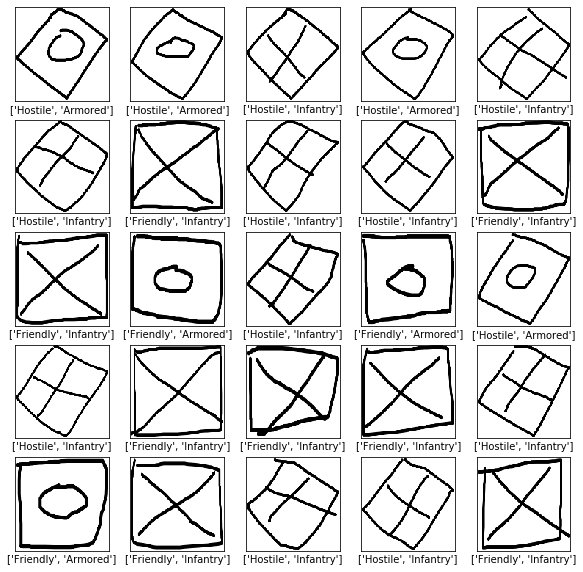

In [33]:
# More visualization with matplotlib
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'][i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(df['label'][i])
plt.show()

In [34]:
for i, array in enumerate(df['pixels']):
    df['pixels'][i] = np.reshape(array, df['pixels'][i].shape + (1,))

train_X, train_y = np.array([array for array in df['pixels'][:25]]), np.array([array for array in df['target'][:25]])
test_X, test_y = np.array([array for array in df['pixels'][23:]]), np.array([array for array in df['target'][23:]])

print(train_X.shape)
print(test_X.shape)

(25, 128, 128, 1)
(3, 128, 128, 1)


In [35]:
# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(half_len_pixel_array, half_len_pixel_array, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# Training
history = model.fit(train_X, train_y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_split=0.1)

Train on 22 samples, validate on 3 samples
Epoch 1/10
22/22 [==============================] - 0s 9ms/sample - loss: 1.0797e-04 - acc: 1.0000 - val_loss: 0.4214 - val_acc: 0.6667
Epoch 2/10
22/22 [==============================] - 0s 9ms/sample - loss: 8.3631e-05 - acc: 1.0000 - val_loss: 0.3652 - val_acc: 0.6667
Epoch 3/10
22/22 [==============================] - 0s 9ms/sample - loss: 1.2986e-04 - acc: 1.0000 - val_loss: 0.2999 - val_acc: 0.6667
Epoch 4/10
22/22 [==============================] - 0s 9ms/sample - loss: 2.1642e-04 - acc: 1.0000 - val_loss: 0.2342 - val_acc: 1.0000
Epoch 5/10
22/22 [==============================] - 0s 9ms/sample - loss: 2.6020e-04 - acc: 1.0000 - val_loss: 0.1739 - val_acc: 1.0000
Epoch 6/10
22/22 [==============================] - 0s 9ms/sample - loss: 1.9611e-04 - acc: 1.0000 - val_loss: 0.1251 - val_acc: 1.0000
Epoch 7/10
22/22 [==============================] - 0s 9ms/sample - loss: 1.0282e-04 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 1.0000
Epoch

3/3 - 0s - loss: 0.0316 - acc: 1.0000


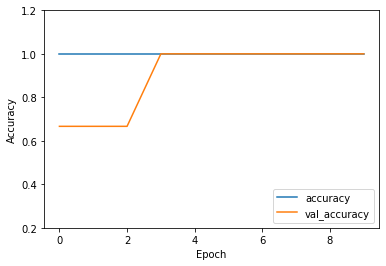

In [40]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)

The prediction of the new digit is: ('Hostile', 'Infantry') - It's number is: 3
The actual label is: ('Hostile', 'Infantry')


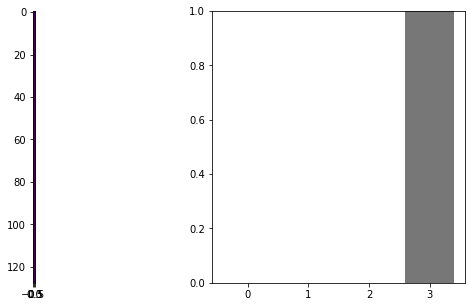

The prediction of the new digit is: ('Friendly', 'Infantry') - It's number is: 1
The actual label is: ('Friendly', 'Infantry')


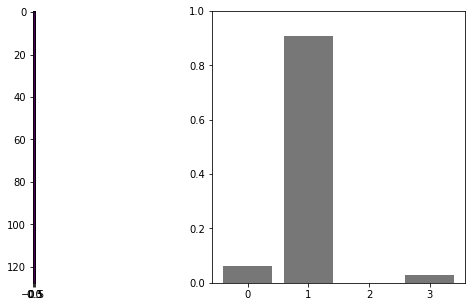

The prediction of the new digit is: ('Friendly', 'Infantry') - It's number is: 1
The actual label is: ('Friendly', 'Infantry')


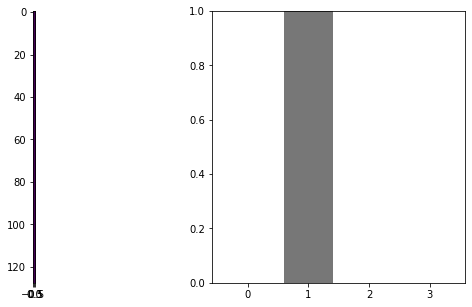

In [43]:
for i in range(3):
    model_prediction = model.predict(np.array([test_X[i]]))
    prediction = np.argmax(model_prediction)

    print(f"The prediction of the new digit is: {LABELS[prediction]} - It's number is: {test_y[i]}")
    print(f"The actual label is: {LABELS[test_y[i]]}")
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(test_X[i][0])

    plt.subplot(1, 2, 2)
    plt.xticks([i for i in range(len(LABELS))])
    plt.bar(range(len(LABELS)), model_prediction[0][0:len(LABELS)], color="#777777")
    plt.ylim(0.0, 1.0)

    plt.show()